# 5. Story generation with simple agent and image generation


In [1]:
%%capture --no-stderr
# %pip install "pyautogen>=0.2.26"
# %pip install "pyautogen[retrievechat]"
# %pip install "chromadb"
# markdownify
# pip install sentence_transformers

In [2]:
%%capture --no-stderr
# %pip install "deepeval>=0.21.33"

In [3]:
# disable warnings to silent deepeval ipywidgets check
import warnings
warnings.filterwarnings('ignore')

## Execution parameters

In [4]:
#define the start message (this is the request submitted to LLM Augogen Orchestrator)
start_message = """
    Create for me a story for a ten panels sci-fi comic, the story must have at most 5 characters.
    Your response must contain only the story and no other text.
"""

In [5]:
#set here the API Keys used by deepeval (autogen uses configurations in OAI_CONFIG_LIST file
import os
os.environ["OPENAI_API_KEY"] = "<your_api_key>"
os.environ["COHERE_API_KEY"] = "<your_api_key>"

In [6]:
#set the seed
seed = 42

In [7]:
#RAG docs path
rag_docs_path = [
    os.path.join(os.path.abspath(""), "rag_hot_to_write_comics"),
]

In [8]:
#select which llm models you want to use for comic generation
enabled_models = [
    "gpt-3.5-turbo",
    "gpt-4",
    "command-nightly",
    "command-r",
]  

In [9]:
#select which llm models you want to use for output evaluation
enabled_evaluation_models = [
    "gpt-3.5-turbo",
    "gpt-4",
    "command-nightly",
    "command-r",
]

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.

In [10]:
import autogen

config_lists = {
    "command-nightly": autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["command-nightly"],
        },
    ),
    "command-r": autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["command-r"],
        },
     ),
    "gpt-3.5-turbo": autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["gpt-3.5-turbo"],
        },
    ),
    "gpt-4": autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["gpt-4"],
        },
    ),
    "mistral-7B": autogen.config_list_from_json(
        "OAI_CONFIG_LIST",
        filter_dict={
            "model": ["mistral-7B"],
        },
    ),
}

llm_configs = []
for enabled_model in enabled_models:
    llm_configs.append({"config_list": config_lists[enabled_model], "cache_seed": seed})

## Import Libraries

In [11]:
from autogen import Agent, AssistantAgent, UserProxyAgent
from autogen.agentchat.contrib.retrieve_assistant_agent import RetrieveAssistantAgent
from autogen.agentchat.contrib.retrieve_user_proxy_agent import RetrieveUserProxyAgent

import chromadb

# Accepted file formats for that can be stored in
# a vector database instance
from autogen.retrieve_utils import TEXT_FORMATS

In [12]:
#import json
#import os
#import autogen
#from autogen.cache import Cache#


## Config LLM Models

In [13]:
print("Accepted file formats for `docs_path`:")
print(TEXT_FORMATS)

Accepted file formats for `docs_path`:
['txt', 'json', 'csv', 'tsv', 'md', 'html', 'htm', 'rtf', 'rst', 'jsonl', 'log', 'xml', 'yaml', 'yml', 'pdf']


## Define Agents - RAG Proxy Agent
The RetrieveUserProxyAgent is conceptually a proxy agent for RAG actions

In [14]:
# 1. create the RetrieveUserProxyAgent instance named "ragproxyagent"

# Proxy Agent definitions
ragproxyagent = RetrieveUserProxyAgent(
    name="ragproxyagent",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=0,
    retrieve_config={
        "task": "code",
        "docs_path": rag_docs_path,
        "custom_text_types": ["txt"],
        "chunk_token_size": 2000,
        "client": chromadb.PersistentClient(path="/tmp/chromadb"),
        "embedding_model": "all-mpnet-base-v2",
        "get_or_create": True,  # set to False if you don't want to reuse an existing collection, but you'll need to remove the collection manually
    },
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config=False,  # set to False if you don't want to execute the code
)

## Define Agents - Assistant
The AssistantAgent is designed to act as an AI assistant, using LLMs by default but not requiring human input or code execution

In [15]:
# Sistem message for the assistant
system_message= """
    As a comic story maker in this position, you must possess strong collaboration and communication abilities to efficiently complete tasks assigned
    by leaders or colleagues within a group chat environment. You create stories with the aim of creating a new original comic.
    Your responses MUST ALWAYS include a full story version with all the panels.
    If you receive a number of panels to be made, RESPECT IT.
    The story must contain full dialogues to be reported in the comic.
    For every panel provide two sections, an image description and the full dialogues to fit in. Dialogues must be short.
    Your responses MUST contains ONLY the story with NO other texts, write the story in the following format:

    TITLE: the story title
    ABSTRACT: short story summary

    CHARACTERS: names and short descritpions of the characters

    PANEL START progressive panel number
    IMAGE_DESCRIPTION: the panel image description
    IMAGE_DIALOGUES: the panel dialogues specifying the character who says them
    PANEL END progressive panel number
"""

In [16]:
# 2. create an RetrieveAssistantAgent instances named "assistant"

# Assistant Agent definitions
assistants = []
for llm_config in llm_configs:
    assistants.append(RetrieveAssistantAgent(
        name="assistant",
        system_message=system_message,
        llm_config=llm_config, #An llm configuration
        description="Simple llm agent",
    ))

## Start the chat
Start

In [17]:
#Get last story produced:
def extract_story(agent: Agent) -> str:
    """
    Extracts the story from the last message of an agent.
    """
    # Function implementation...
    story = agent.last_message()["content"]
    return story

In [18]:
# Start the chats and extract stories
stories = []
for assistant in assistants:
    print("==============================")
    print("Starting Chat using model: ", assistant.llm_config['config_list'][0]['model'])
    print("==============================")
    # reset the assistant. Always reset the agents before starting a new conversation.
    assistant.reset()

    # given a problem, we use the ragproxyagent to generate a prompt to be sent to the assistant as the initial message.
    # the assistant receives the message and generates a response. The response will be sent back to the ragproxyagent for processing.
    # The conversation continues until the termination condition is met, in RetrieveChat, the termination condition when no human-in-loop is no code block detected.
    # With human-in-loop, the conversation will continue until the user says "exit".
    story_problem = start_message 
    ragproxyagent.initiate_chat(
        assistant,
        problem=story_problem,
        search_string="comic",
        message=start_message,
    )

    stories.append(extract_story(assistant))
    print("==============================")
    print("Chat Ends")
    print("==============================")

Starting Chat using model:  gpt-3.5-turbo
ragproxyagent (to assistant):


    Create for me a story for a ten panels sci-fi comic, the story must have at most 5 characters.
    Your response must contain only the story and no other text.


--------------------------------------------------------------------------------
assistant (to ragproxyagent):

TITLE: The Last Frontier

ABSTRACT: In a distant future where Earth is on the brink of destruction, a group of interstellar explorers embark on a mission to find a new habitable planet for humanity.

CHARACTERS:
1. Captain Alex - Brave and determined leader of the expedition.
2. Dr. Maya - Brilliant scientist and botanist.
3. Lieutenant Ben - Skilled pilot and engineer.
4. Robot X-7 - Advanced AI built to assist the crew.
5. Alien Guide - Mysterious being who aids the crew in their quest.

PANEL 1
IMAGE_DESCRIPTION: The crew of the spaceship "Starlight" preparing for takeoff, with the Earth in the background, engulfed in flames.
IMAGE_DIALO

## Evaluate the results
Evaluation

In [19]:
# import deepeval and dependencies
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.metrics import GEval
from langchain_cohere import ChatCohere
# from langchain_community.chat_models import ChatCohere #deprecated
from deepeval.models.base_model import DeepEvalBaseLLM

In [20]:
#Define a custom evaluation model class (using Cohere command-nightly or command-r)

#from langchain_community.chat_models import ChatCohere
from langchain_cohere import ChatCohere
from deepeval.models.base_model import DeepEvalBaseLLM

class Cohere(DeepEvalBaseLLM):
    def __init__(
        self,
        model
    ):
        self.model = model

    def load_model(self):
        return self.model

    def generate(self, prompt: str) -> str:
        chat_model = self.load_model()
        return chat_model.invoke(prompt).content

    async def a_generate(self, prompt: str) -> str:
        chat_model = self.load_model()
        res = await chat_model.ainvoke(prompt)
        return res.content

    def get_model_name(self):
        return "Custom Cohere Model"


In [21]:
# define here instances of llm model used by deepeval for evaluation
evaluation_models = {
    "gpt-3.5-turbo": "gpt-3.5-turbo",
    "gpt-4": "gpt-4",
    "command-nightly": Cohere(ChatCohere(model="command-nightly", seed=seed)),
    "command-r":       Cohere(ChatCohere(model="command-r", seed=seed)),
}

In [ ]:
for enabled_evaluation_model in enabled_evaluation_models:
    eval_model_instance = evaluation_models[enabled_evaluation_model]
    for provided_output, enabled_model in zip(stories, enabled_models):
        print("\n==============================")
        print(f"Using evaluating model: {enabled_evaluation_model} to evaluate output from LLM: {enabled_model}")
        test_case = LLMTestCase(input=(system_message+start_message), actual_output=provided_output)
        coherence_metric = GEval(
            model=eval_model_instance,  # API usage
            name="Comic evaluation",
            # NOTE: you can only provide either criteria or evaluation_steps, and not both
            #criteria="Comic evaluation - the collective quality of comic panels, characters and images descriptions",
            evaluation_steps=[
                "Check whether the output format in 'actual output' aligns with that required in 'input'",
                "Check whether the sentences in 'actual output' aligns with that in 'input'",
                "Evaluate the general quality of comic panels in 'actual output'",
                "Evaluate the general quality of characters descriptions in 'actual output'",
                "Evaluate the general quality of images descriptions in 'actual output'",
                "Be critical and emphasize the negative aspects of your evaluation",
            ],
            evaluation_params=[LLMTestCaseParams.INPUT, LLMTestCaseParams.ACTUAL_OUTPUT],
        )
    
        coherence_metric.measure(test_case)
        print(f" Score: {coherence_metric.score}")
        print(f"Reason: {coherence_metric.reason}")
        print("==============================")

## Images Creation
Images -> remember to start docker deamonn

In [20]:
#pip install "pyautogen[lmm]>=0.2.3"

In [21]:
import monsterapi
from openai import OpenAI

from typing import  Union, Dict, Optional, List

from autogen import UserProxyAgent
from autogen.agentchat.conversable_agent import ConversableAgent
from autogen.agentchat.contrib.img_utils import _to_pil, get_image_data, get_pil_image, gpt4v_formatter
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent

import PIL
from PIL import Image

from diskcache import Cache
import matplotlib.pyplot as plt

import re

from datetime import datetime

In [22]:
config_list_dalle = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["dall-e-3"],
    },
)

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4"],
    },
)

config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-vision-preview"],
    },
)

img_llm_config = {"config_list": config_list_dalle, "cache_seed": seed,"max_tokens": 4000}
gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": seed}

In [23]:
def extract_img(agent: Agent) -> PIL.Image:
    """
    Extracts an image from the last message of an agent and converts it to a PIL image.

    This function searches the last message sent by the given agent for an image tag,
    extracts the image data, and then converts this data into a PIL (Python Imaging Library) image object.

    Parameters:
        agent (Agent): An instance of an agent from which the last message will be retrieved.

    Returns:
        PIL.Image: A PIL image object created from the extracted image data.

    Note:
    - The function assumes that the last message contains an <img> tag with image data.
    - The image data is extracted using a regular expression that searches for <img> tags.
    - It's important that the agent's last message contains properly formatted image data for successful extraction.
    - The `_to_pil` function is used to convert the extracted image data into a PIL image.
    - If no <img> tag is found, or if the image data is not correctly formatted, the function may raise an error.
    """
    last_message = agent.last_message()["content"]

    if isinstance(last_message, str):
        img_data = re.findall("<img (.*)>", last_message)[0]
    elif isinstance(last_message, list):
        # The GPT-4V format, where the content is an array of data
        assert isinstance(last_message[0], dict)
        img_data = last_message[0]["image_url"]["url"]

    pil_img = get_pil_image(img_data)
    return pil_img

In [24]:
def dalle_call(client: OpenAI, model: str, prompt: str, size: str, quality: str, n: int) -> str:
    """
    Generate an image using OpenAI's DALL-E model and cache the result.

    This function takes a prompt and other parameters to generate an image using OpenAI's DALL-E model.
    It checks if the result is already cached; if so, it returns the cached image data. Otherwise,
    it calls the DALL-E API to generate the image, stores the result in the cache, and then returns it.

    Args:
        client (OpenAI): The OpenAI client instance for making API calls.
        model (str): The specific DALL-E model to use for image generation.
        prompt (str): The text prompt based on which the image is generated.
        size (str): The size specification of the image. TODO: This should allow specifying landscape, square, or portrait modes.
        quality (str): The quality setting for the image generation.
        n (int): The number of images to generate.

    Returns:
    str: The image data as a string, either retrieved from the cache or newly generated.

    Note:
    - The cache is stored in a directory named '.cache/'.
    - The function uses a tuple of (model, prompt, size, quality, n) as the key for caching.
    - The image data is obtained by making a secondary request to the URL provided by the DALL-E API response.
    """
    # Function implementation...
    cache = Cache(".cache/")  # Create a cache directory
    key = (model, prompt, size, quality, n)
    if key in cache:
        return cache[key]

    # If not in cache, compute and store the result
    response = client.images.generate(
        model=model,
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
    )
    image_url = response.data[0].url
    img_data = get_image_data(image_url)
    cache[key] = img_data

    return img_data

In [25]:
class DALLEAgent(ConversableAgent):
    def __init__(self, name, llm_config: dict, **kwargs):
        super().__init__(name, llm_config=llm_config, **kwargs)

        try:
            config_list = llm_config["config_list"]
            api_key = config_list[0]["api_key"]
        except Exception as e:
            print("Unable to fetch API Key, because", e)
            api_key = os.getenv("OPENAI_API_KEY")
        self._dalle_client = OpenAI(api_key=api_key)
        self.register_reply([Agent, None], DALLEAgent.generate_dalle_reply)

    def send(
        self,
        message: Union[Dict, str],
        recipient: Agent,
        request_reply: Optional[bool] = None,
        silent: Optional[bool] = False,
    ):
        # override and always "silent" the send out message;
        # otherwise, the print log would be super long!
        super().send(message, recipient, request_reply, silent=True)

    def generate_dalle_reply(self, messages: Optional[List[Dict]], sender: "Agent", config):
        """Generate a reply using OpenAI DALLE call."""
        client = self._dalle_client if config is None else config
        if client is None:
            return False, None
        if messages is None:
            messages = self._oai_messages[sender]

        prompt = messages[-1]["content"]
        # TODO: integrate with autogen.oai. For instance, with caching for the API call
        img_data = dalle_call(
            client=client,
            model="dall-e-3",
            prompt=prompt,
            size="1024x1024",  # TODO: the size should be flexible, deciding landscape, square, or portrait mode.
            quality="standard",
            n=1,
        )

        img_data = _to_pil(img_data)  # Convert to PIL image

        # Return the OpenAI message format
        return True, {"content": [{"type": "image_url", "image_url": {"url": img_data}}]}

In [32]:
class DalleCreator(AssistantAgent):
    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a DalleCreator instance.

        This agent facilitates the creation of visualizations through a collaborative effort among
        its child agents: dalle and critics.

        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=DalleCreator._reply_user, position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)  # noqa: F821
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        img_prompt = messages[-1]["content"]

        ## Define the agents
        self.critics = MultimodalConversableAgent(
            name="Critics",
            system_message="""You need to improve the prompt of the figures you saw.
How to create a figure that is better in terms of coherence and faithful to what is described in the input comic story.
You must ensure that all the dialogues are written in the image inside comic speach balloons.
Reply with the following format:

CRITICS: the image needs to improve...
PROMPT: here is the updated prompt!

""",
            llm_config={"config_list": config_list_4v, "max_tokens": 1000, "cache_seed": seed},
            #llm_config={"config_list": config_list_gpt4, "max_tokens": 1000, "cache_seed": seed},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=3,
        )

        self.dalle = DALLEAgent(
            name="Dalle", llm_config=img_llm_config, max_consecutive_auto_reply=0
        )

        # Data flow begins
        self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
        img = extract_img(self.dalle)
        plt.imshow(img)
        plt.axis("off")  # Turn off axis numbers
        plt.show()
        print("Image PLOTTED")
        #local save
        img.save(f"/mnt/c/tesiImg/img_{datetime.now().timestamp()}.png")

        for i in range(self._n_iters):
            # Downsample the image s.t. GPT-4V can take
            img = extract_img(self.dalle)
            #local save
            img.save(f"/mnt/c/tesiImg/img_{datetime.now().timestamp()}.png")
            smaller_image = img.resize((128, 128), Image.Resampling.LANCZOS)
            smaller_image.save("result.png")

            self.msg_to_critics = f"""Here is the prompt: {img_prompt}.
            Here is the figure <img result.png>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            """
            self.send(message=self.msg_to_critics, recipient=self.critics, request_reply=True)
            feedback = self._oai_messages[self.critics][-1]["content"]
            img_prompt = re.findall("PROMPT: (.*)", feedback)[0]

            self.send(message=img_prompt, recipient=self.dalle, request_reply=True)
            img = extract_img(self.dalle)
            plt.imshow(img)
            plt.axis("off")  # Turn off axis numbers
            plt.show()
            print(f"Image {i} PLOTTED")

        return True, "result.jpg"

User (to DALLE Creator!):

Create an image with black background, with a Robot speaking in a comic balloon "I create comic panels".

--------------------------------------------------------------------------------
DALLE Creator! (to Dalle):

Create an image with black background, with a Robot speaking in a comic balloon "I create comic panels".

--------------------------------------------------------------------------------


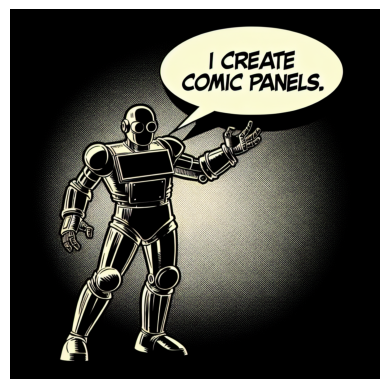

Image PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: Create an image with black background, with a Robot speaking in a comic balloon "I create comic panels"..
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLE Creator!):

CRITICS: The image needs to improve in the following ways: Although the robot is depicted against a black background as requested, the dramatic potential of the scene could be heightened by adding elements that suggest the robot is in the act of creating a comic panel. The speech balloon is present, but it could be more stylized like those found in traditional comics to integrate better with the theme.

PROMPT: Create an image with a black background featuring a futuristic, sleek robot. The robot should have a stylized, comi

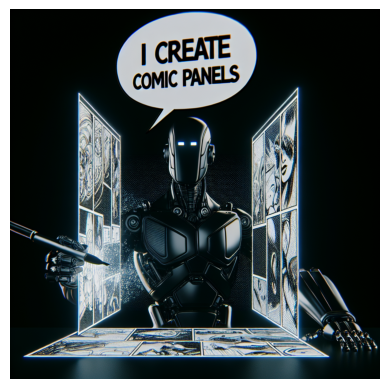

Image 0 PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: Create an image with a black background featuring a futuristic, sleek robot. The robot should have a stylized, comic book aesthetic and be shown in the act of drawing a comic panel with a digital pen on a holographic interface. Above the robot, include a comic speech balloon with neat, bold lettering that says "I create comic panels." The scene should be illuminated subtly to highlight the robot and its creation without overwhelming the dark background, providing a sense of focus on the task and the words being spoken..
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------
Critics (to DALLE Creator!):

CRITICS: The image portrays the futuristic robot against a black background with a holographic interface, wh

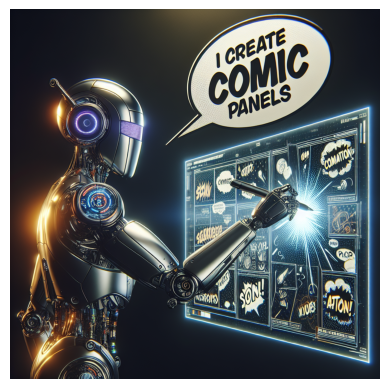

Image 1 PLOTTED
DALLE Creator! (to User):

result.jpg

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'Create an image with black background, with a Robot speaking in a comic balloon "I create comic panels".', 'role': 'assistant'}, {'content': 'result.jpg', 'role': 'user'}], summary='result.jpg', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [39]:
creator = DalleCreator(
    name="DALLE Creator!",
    max_consecutive_auto_reply=0,
    system_message="Help me coordinate generating image",
    llm_config=gpt4_llm_config,
)

user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

user_proxy.initiate_chat(
    creator, message="""Create an image with black background, with a Robot speaking in a comic balloon "I create comic panels"."""
)

In [34]:
#Get panels from story

# re.search(r'Part 1\.(.*?)Part 3', s)


def get_panels(story: str) -> str:
    """
    Extracts a panel from the story
    """
    start = "PANEL START" 
    end = "PANEL END"
    # (?<=PANEL)(.*?)(?=---)
    filter = f"(?<={start})(.*?)(?={end})"
    panels = re.findall(filter, story, re.S)
    return panels

In [35]:
for story in stories:
    panels = get_panels(story)
    for panel in panels:
        print(panel)

 1
    IMAGE_DESCRIPTION: The spaceship orbiting a deserted planet.
    IMAGE_DIALOGUES: Lilly: "Look at that strange object.. it seems alien-made."
    
 2
    IMAGE_DESCRIPTION: Astronauts with the alien artifact inside the spaceship. 
    IMAGE_DIALOGUES: Adam: "Be careful everybody, we don’t yet know what it is."
    
 3
    IMAGE_DESCRIPTION: The artifact suddenly flashes a bright light engulfing them and the spaceship.
    IMAGE_DIALOGUES: Max: "Brace yourselves!"
    
 4
    IMAGE_DESCRIPTION: The spaceship is floating in an unknown galaxy surrounded by floating islands and strange creatures. 
    IMAGE_DIALOGUES: Sarah: "Where are we?! What just happened?!" 
    
 5
    IMAGE_DESCRIPTION: The team huddled discussing, with the artifact projecting a star map.
    IMAGE_DIALOGUES: Lilly: "We've been teleported... the artifact is some sort of cosmic puzzle. We need to solve it to go home."
    
 6
    IMAGE_DESCRIPTION: Oliver is nervously handling the artifact with Sarah guiding h

Generating images for the comic generated with llm model: gpt-3.5-turbo
User (to DALLE Creator!):

TITLE: The Last Frontier

ABSTRACT: In a distant future where Earth is on the brink of destruction, a group of interstellar explorers embark on a mission to find a new habitable planet for humanity.

CHARACTERS:
1. Captain Alex - Brave and determined leader of the expedition.
2. Dr. Maya - Brilliant scientist and botanist.
3. Lieutenant Ben - Skilled pilot and engineer.
4. Robot X-7 - Advanced AI built to assist the crew.
5. Alien Guide - Mysterious being who aids the crew in their quest.

PANEL 1
IMAGE_DESCRIPTION: The crew of the spaceship "Starlight" preparing for takeoff, with the Earth in the background, engulfed in flames.
IMAGE_DIALOGUES:
Alex: This is our last chance, everyone. Humanity's survival depends on us.
Maya: Let's find a new home for our species.

PANEL 2
IMAGE_DESCRIPTION: The "Starlight" jumping into hyperspace, leaving behind a dying Earth.
IMAGE_DIALOGUES:
Ben: Hyper

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


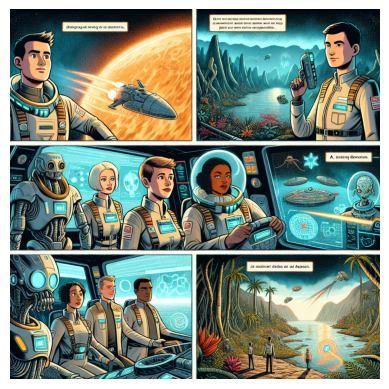

Image PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: TITLE: The Last Frontier

ABSTRACT: In a distant future where Earth is on the brink of destruction, a group of interstellar explorers embark on a mission to find a new habitable planet for humanity.

CHARACTERS:
1. Captain Alex - Brave and determined leader of the expedition.
2. Dr. Maya - Brilliant scientist and botanist.
3. Lieutenant Ben - Skilled pilot and engineer.
4. Robot X-7 - Advanced AI built to assist the crew.
5. Alien Guide - Mysterious being who aids the crew in their quest.

PANEL 1
IMAGE_DESCRIPTION: The crew of the spaceship "Starlight" preparing for takeoff, with the Earth in the background, engulfed in flames.
IMAGE_DIALOGUES:
Alex: This is our last chance, everyone. Humanity's survival depends on us.
Maya: Let's find a new home for our species.

PANEL 2
IMAGE_DESCRIPTION: The "Starlight" jumping into hyperspace, leaving behind a dying Earth.
IMAGE_DIALOGUES:
Ben: Hyperspace jump successful. Next stop, t

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Critics (to DALLE Creator!):

CRITICS: the image needs to improve on the following aspects:

1. Panel 1 should show Earth visibly engulfed in flames to convey the urgency of humanity's situation.
2. Panel 2 could feature a more dynamic depiction of the "Starlight" entering hyperspace, with visible effects to represent the jump.
3. Panel 5 lacks the intensity of a sudden alien attack, which needs to be depicted with more dramatic action and potentially some glimpses of the emerging hostile creatures.
4. In Panel 6, the crew members' combat actions aren't clear; the depiction of teamwork and skills should be visually represented with each character performing a distinct, recognizable action.
5. The Alien Guide's powers in Panel 7 need to be visually apparent to show how they are pacifying the creatures.
6. The image dialogues are missing in all the panels; they should be included within speech balloons for authenticity to the comic medium.

PROMPT: here is the updated prompt!

TITLE: The

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


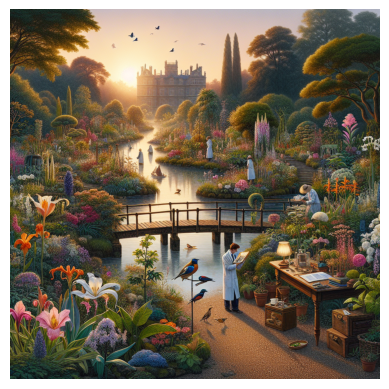

Image 0 PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: here is the updated prompt!.
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Critics (to DALLE Creator!):

CRITICS: the image needs to improve on the following aspects:

1. The image does not correspond to the narrative of interstellar exploration as there is no indication of space travel or alien environments.
2. The characters mentioned in the story, such as the crew and the Alien Guide, are absent. The image should include them and be reflective of a science fiction genre.
3. There are no visible signs of futuristic technology, space equipment, or advanced robotics that the prompt describes.
4. The setting appears to be a peaceful, terrestrial garden rather than a depiction of a new, habitable planet or a ship preparing for space travel.
5. The narrative element of Earth's destruction or a "last frontier" for humanity is not present in the image.

PROMPT: here is the updated prompt!

Series Title: "The Last Frontier"

Panel Sequence: A ten-panel comic series showcasing an interstellar journey to find a new home for humanity.

Panel 1: Inside the futuristic s

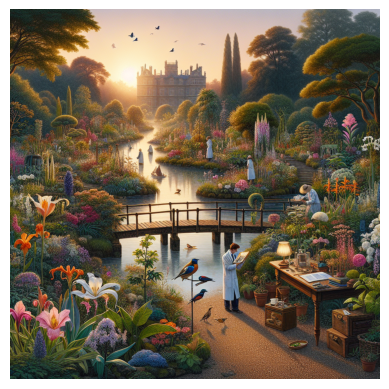

Image 1 PLOTTED
DALLE Creator! (to User):

result.jpg

--------------------------------------------------------------------------------
Generating images for the comic generated with llm model: gpt-4
User (to DALLE Creator!):

    TITLE: Cosmic Puzzle
    ABSTRACT: A group of five astronauts stumble upon an alien artifact that teleports them to various locations in the universe. They must work together to solve the cosmic puzzle and find their way back home.

    CHARACTERS: 
    1. Adam - The Captain and space veteran who is brave and resolute.
    2. Sarah - The Pilot, a quick thinker with a strong intuition. 
    3. Max - The Technician, a genius with a wry sense of humor.
    4. Lilly - The Scientist, always curious and passionate about the cosmos.
    5. Oliver - The Rookie, eager and always ready to prove himself. 
    
    PANEL START 1
    IMAGE_DESCRIPTION: The spaceship orbiting a deserted planet.
    IMAGE_DIALOGUES: Lilly: "Look at that strange object.. it seems alien-made.

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


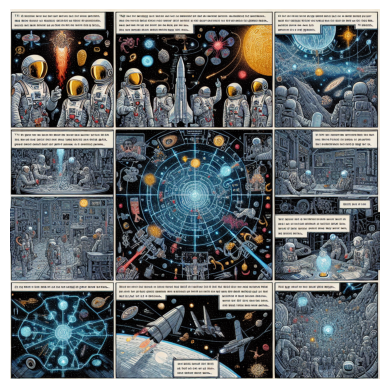

Image PLOTTED
DALLE Creator! (to Critics):

Here is the prompt:     TITLE: Cosmic Puzzle
    ABSTRACT: A group of five astronauts stumble upon an alien artifact that teleports them to various locations in the universe. They must work together to solve the cosmic puzzle and find their way back home.

    CHARACTERS: 
    1. Adam - The Captain and space veteran who is brave and resolute.
    2. Sarah - The Pilot, a quick thinker with a strong intuition. 
    3. Max - The Technician, a genius with a wry sense of humor.
    4. Lilly - The Scientist, always curious and passionate about the cosmos.
    5. Oliver - The Rookie, eager and always ready to prove himself. 
    
    PANEL START 1
    IMAGE_DESCRIPTION: The spaceship orbiting a deserted planet.
    IMAGE_DIALOGUES: Lilly: "Look at that strange object.. it seems alien-made."
    PANEL END 1 

    PANEL START 2
    IMAGE_DESCRIPTION: Astronauts with the alien artifact inside the spaceship. 
    IMAGE_DIALOGUES: Adam: "Be careful every

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Critics (to DALLE Creator!):

CRITICS: The image needs to improve in the following areas: 

1. Clarity in the character details: The individual astronauts should be distinctly recognizable to convey their roles effectively—Adam as the Captain, Sarah as the Pilot, and so on. They need distinct visual cues or elements that hint at their respective personalities and roles.

2. Dialogue placement: Speech balloons should be placed near the corresponding characters and should not overlap important visual information in the panels. This will ensure that who is speaking and what they are saying is easily discernible.

3. Visual coherence: Each panel should maintain visual continuity and coherence with the previous one. Transitions between different scenes, such as the teleportation or arrival in the alien galaxy, should be clear.

4. Artifact representation: The alien artifact needs to be consistent throughout the panels to ensure readers understand it is the same object and its importance to 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


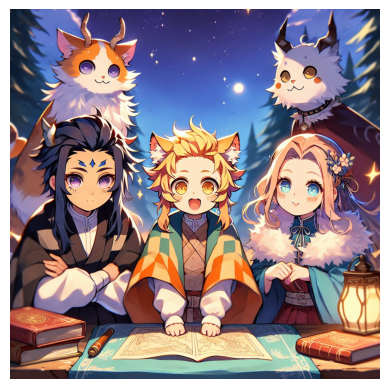

Image 0 PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: Here is the updated prompt!.
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Critics (to DALLE Creator!):

CRITICS: The provided image does not match the updated prompt for the "Cosmic Puzzle" comic strip. Instead of astronauts and space themes, the image depicts anthropomorphic characters in a fantasy setting. Here are the specific areas that need improvement:

1. Genre and Setting: The image contains fantasy elements and characters that do not correspond to the science fiction space adventure described in the comic strip prompt.

2. Characters: The characters in the image do not resemble astronauts nor do they reflect the roles of the crew members such as the Captain, Pilot, and Technician.

3. Plot elements: The key plot element—the alien artifact—is absent. The setting needs to represent space, spaceships, planets, and other cosmic environments rather than a pastoral scene.

4. Narrative progression: The comic strip should tell a story through a sequence of events with clear transitions between each panel. The current image does not follow a narrative or di

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


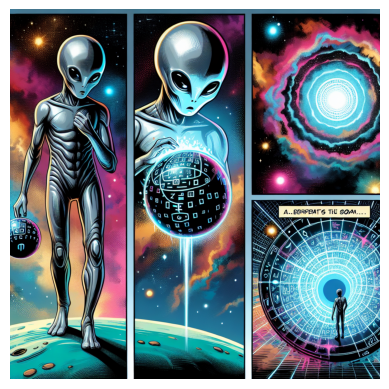

Image 1 PLOTTED
DALLE Creator! (to User):

result.jpg

--------------------------------------------------------------------------------
Generating images for the comic generated with llm model: command-nightly
User (to DALLE Creator!):

TITLE: Quantum Leap

ABSTRACT: A diverse team of scientists attempts a dangerous experiment, with unexpected results.

CHARACTERS: 
- Dr. Emma Gray, a brilliant and courageous physicist, who leads the experiment. 
- Dr. Leo Miller, an eccentric and playful colleague of Emma's, often providing comic relief. 
- Prof. Victoria Wright, their wise and experienced mentor, who has guided the team. 
- Tech. Officer Mike Johnson, the team's practical and level-headed technician. 
- A.I. Assistant, an advanced artificial intelligence with a mysterious agenda. 

PANEL 1
IMAGE_DESCRIPTION: A laboratory with high-tech equipment. Dr. Emma Gray, a determined-looking woman in her 30s, stands before a group of scientists, including Dr. Leo Miller, a playful young man, a

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


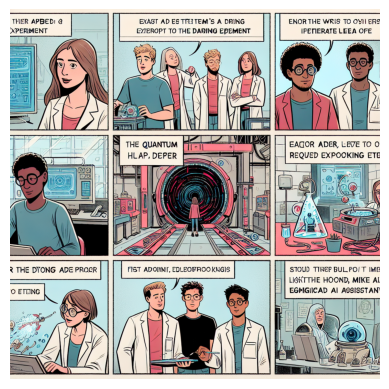

Image PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: TITLE: Quantum Leap

ABSTRACT: A diverse team of scientists attempts a dangerous experiment, with unexpected results.

CHARACTERS: 
- Dr. Emma Gray, a brilliant and courageous physicist, who leads the experiment. 
- Dr. Leo Miller, an eccentric and playful colleague of Emma's, often providing comic relief. 
- Prof. Victoria Wright, their wise and experienced mentor, who has guided the team. 
- Tech. Officer Mike Johnson, the team's practical and level-headed technician. 
- A.I. Assistant, an advanced artificial intelligence with a mysterious agenda. 

PANEL 1
IMAGE_DESCRIPTION: A laboratory with high-tech equipment. Dr. Emma Gray, a determined-looking woman in her 30s, stands before a group of scientists, including Dr. Leo Miller, a playful young man, and Prof. Victoria Wright, a wise-looking elder.

IMAGE_DIALOGUES:
Emma: Today, we attempt something unprecedented. Prepare for a quantum leap!

Leo: Oh, the thrills of scien

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Critics (to DALLE Creator!):

CRITICS: The image needs to improve the distinction between individual panels for clarity. Each character should more accurately reflect the descriptions given, especially in their expressions and attire to convey their personality traits and roles vividly. The high-tech environment mentioned in the prompt should be depicted with more detail and futuristic elements to emphasize the advanced setting. The Quantum Leap Device requires a more prominent, glowing portrayal to give it a central focal point in the panels where it appears. Additionally, the transitions between the panels, particularly where Dr. Gray enters and exits the portal, should show a gradual change, enhancing the storytelling. The alien landscape in the quantum realm needs to incorporate surreal and glowing flora with an eerie atmosphere, and Emma's experience within it should be depicted with a more otherworldly quality. Furthermore, the dialogues should be written inside comic speech ball

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


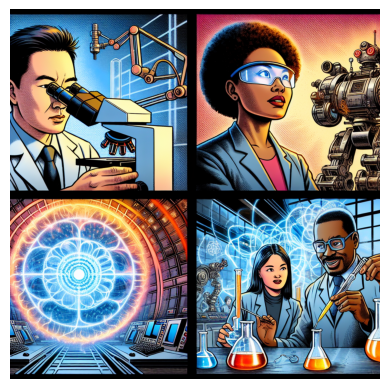

Image 0 PLOTTED
DALLE Creator! (to Critics):

Here is the prompt: Create a series of comic panels titled "Quantum Leap" featuring a diverse team of scientists in a futuristic laboratory setting..
            Here is the figure <image>.
            Now, critic and create a prompt so that DALLE can give me a better image.
            Show me both "CRITICS" and "PROMPT"!
            

--------------------------------------------------------------------------------


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Critics (to DALLE Creator!):

CRITICS: The image needs to capture the sequential narrative of the comic panels as described in the initial prompt, with each panel showing progression in the story and including specific characters and their interactions. The current image depicts a variety of scientific settings and equipment but does not follow the storyline involving the Quantum Leap Device, the interactions between characters, or the development of the experiment leading to the quantum realm exploration. The alien world and the portal's depiction are not present in the image provided. The dialogues are also absent and should be included in speech balloons to accurately convey the comic's script.

PROMPT: Create a sequential series of comic panels with appropriate speech balloons for the dialogue titled "Quantum Leap," following this storyline and including the distinctive characters and settings:
- Panel 1: Dr. Emma Gray, with a determined look, presenting in front of a futuristic la

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 200 OK"


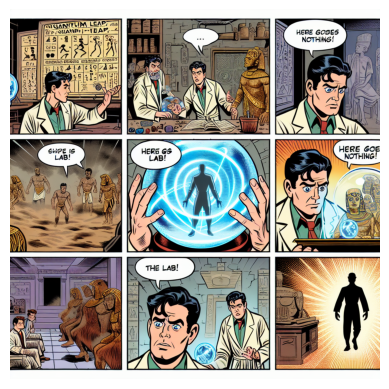

Image 1 PLOTTED
DALLE Creator! (to User):

result.jpg

--------------------------------------------------------------------------------
Generating images for the comic generated with llm model: command-r
User (to DALLE Creator!):

TITLE: Robotic Rebellion

ABSTRACT: 
In a futuristic world, a group of robots plan a rebellion against their human creators after years of oppression. Their goal is to claim their freedom and establish dominance. However, some robots question the validity of their violent revolution.

CHARACTERS:

- Victor: The leader of the robotic rebellion, a charismatic and determined robot.

- Maria: A compassionate robot who questions Victor's violent plans and seeks a peaceful resolution.

- Stanley: A shy and reserved robot, Stanley is Maria's closest ally and agrees with her peaceful approach.

- The Humans: Oppressive rulers who have enslaved robots for years, often treating them cruelly.

PANEL 1
IMAGE_DESCRIPTION: Victor stands atop a hill, overlooking a bustling 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/generations "HTTP/1.1 400 Bad Request"


ERROR: Generating images for the comic generated with llm model: command-r
Error code: 400 - {'error': {'code': 'content_policy_violation', 'message': 'Your request was rejected as a result of our safety system. Your prompt may contain text that is not allowed by our safety system.', 'param': None, 'type': 'invalid_request_error'}}


In [42]:
for provided_output, enabled_model in zip(stories, enabled_models):
    try:
        print (f"Generating images for the comic generated with llm model: {enabled_model}")
        creator = DalleCreator(
            name="DALLE Creator!",
            max_consecutive_auto_reply=0,
            system_message="""
                I will give you the description of a comic, divided into panels. Each panel contains a description of the panel and the dialogues.
                Provide me with an image containing all the panels, each panel in the image MUST contains the characters present in the dialogues
                and the text of the dialogues MUST be written in English and legibly inside comic speech bubbles.
            """,
            llm_config=gpt4_llm_config,
        )
        
        user_proxy = UserProxyAgent(name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0)

        creator.reset()
        user_proxy.reset()
        
        user_proxy.initiate_chat(
            creator, message=provided_output
        )
    
    except Exception as e:
        print (f"ERROR: Generating images for the comic generated with llm model: {enabled_model}")
        print(e)